1.Предскажем цены на недвижимость, используя датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

2.Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей

3.Построить случайный лес, вывести важность признаков

4.Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

5.Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии

6.Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, LassoCV
from sklearn.svm import SVR

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor



C:\Users\AAZam\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Всего то 80 столбцов :)

In [3]:
data.drop(['Id'], axis = 1, inplace=True) #Дубль поле Index

In [4]:
data['ExterQual'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [5]:
ind = list(data.dtypes[data.dtypes == object].index)

for i in ind:
    print(data[i].value_counts())

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype:

*Шкала оценки Poor - Exellent схожа с оценкой бриллиантов и нашими школьными оценками от 1 до 5*

*Судя по описанию признаки OverallQual и OverallCond представляют собой сводную оценку всех остальных признаков (качества и условий) недвижимости. Поэтому будем использовать тип продажи, условия продажи и эти 2 параметра.*

In [6]:
data1 = data[['OverallQual', 'OverallCond', 'SaleType', 'SaleCondition']]
y = data['SalePrice']

Разбиваем признаки на числовые и категориальные

In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OverallQual    1460 non-null   int64 
 1   OverallCond    1460 non-null   int64 
 2   SaleType       1460 non-null   object
 3   SaleCondition  1460 non-null   object
dtypes: int64(2), object(2)
memory usage: 45.8+ KB


In [8]:
cat_feat = list(data1.dtypes[data.dtypes == object].index)
cat_feat

['SaleType', 'SaleCondition']

In [9]:
num_feat = [i for i in data1 if i not in (cat_feat)]
num_feat

['OverallQual', 'OverallCond']

*Для числовых признаков пустые значения можно заменить на медианы чтобы не потерять данные*

In [10]:
num_median = data[num_feat].median().astype('int32')
data[num_feat] = data[num_feat].fillna(num_median)

*Объединяем*

In [11]:
data_x = pd.concat([pd.get_dummies(data1[cat_feat], 
                    columns=cat_feat),
                    data1[num_feat]  ], axis=1)

data_x.head(1)

,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,OverallQual,OverallCond
0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,7,5


*Пробую разные подходы с объединением*

In [12]:
data_y = data1[num_feat].join(pd.get_dummies(data1[cat_feat], columns=cat_feat))

data_y.head(1)

,OverallQual,OverallCond,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7,5,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


### Random Forest и важность признаков

In [13]:
X  = data_x


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [14]:
RFR = RandomForestRegressor(n_estimators=300, max_features=5)

RFR.fit(x_train, y_train)
RFR_pred = RFR.predict(x_test)

y_pred_train, y_pred_test = RFR.predict(x_train), RFR.predict(x_test)

In [15]:
r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)

(0.739388336265965, 0.667481367561253)

In [16]:
def cross_valid (model, metric):
    skf = KFold(n_splits=10, random_state=None, shuffle=False)
    train_metric, test_metric = [], []
    for train_index, test_index in skf.split(X, y):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        model.fit(x_train, y_train)
        y_pred_train, y_pred_test = model.predict(x_train), model.predict(x_test)
        train_metric.append(metric(y_train, y_pred_train))
        test_metric.append (metric(y_test, y_pred_test))
    print(model)
    print('train metric after cross val = ',  round(sum(train_metric)/len(train_metric),5))
    print('test  metric after cross val = ',  round(sum(test_metric)/len(test_metric),5))

In [17]:
cross_valid (model = RFR, metric = r2_score)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
train metric after cross val =  0.74468
test  metric after cross val =  0.66267


In [18]:
headers     = list(X.columns.values)
feature_imp = pd.Series(RFR.feature_importances_,index=headers).sort_values(ascending=False)
f_i_short   = feature_imp

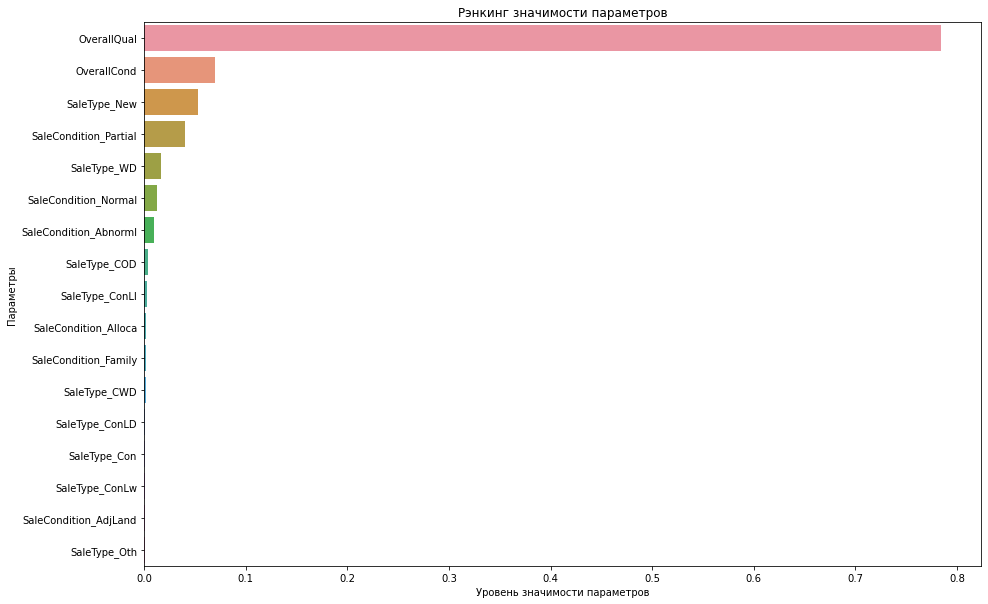

In [19]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=f_i_short, y=f_i_short.index)
plt.xlabel('Уровень значимости параметров')
plt.ylabel('Параметры')
plt.title('Рэнкинг значимости параметров')
plt.show()

*Cократиm количество признаков до 7*

In [20]:
top_feat = list(f_i_short.head(7).index)
data_top_feat = data_x[top_feat]

In [21]:
x  = data_top_feat
Y  = data['SalePrice'].astype('float32')

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 7)

In [22]:
RFR.fit(x_train, y_train)
RFR_pred = RFR.predict(x_test)

y_pred_train, y_pred_test = RFR.predict(x_train), RFR.predict(x_test)

In [23]:
r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)

(0.7396221685635289, 0.6897042471929962)

*Точность незначительно выросла*

### Стекинг

In [24]:
estimators = [
              ('lasso',  LassoCV(random_state=100)),              
              ('sgd',    SGDRegressor()),
              ('ridge',  RidgeCV()),
              ('rfr',    RandomForestRegressor()),
              ('abr',    AdaBoostRegressor())
            ]

In [26]:
from sklearn.ensemble import StackingRegressor

ImportError: cannot import name 'StackingRegressor' from 'sklearn.ensemble' (C:\Users\AAZam\Anaconda3\lib\site-packages\sklearn\ensemble\__init__.py)

In [48]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')


In [49]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)

In [50]:
def get_meta_features(clf, x_train, y_train, x_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(x_train, y_train)):
        
        clf.fit(x_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(x_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(x_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

In [51]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=7)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(clf_lr, x_train, y_train, x_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, x_train, y_train, x_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

LR features...


C:\Users\AAZam\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\AAZam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\AAZam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\AAZam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning

RF features...


C:\Users\AAZam\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [37]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [38]:
clf_lr_meta = LogisticRegression(penalty='l2', C=1)
clf_lr_meta.fit(X_meta_train, y_train)

C:\Users\AAZam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\AAZam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]

In [54]:
r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_meta_test)

(0.7396221685635289, -4.736919823061898)

***Начало было бодрым, а к концу запутался***